## Cross-correlation exmple with Active-Provenance in dispel4py:



### Sample Corss-Correlation Workflow: Description and Components
<br/>

The workflow performs and visualises the cross correlation matrix between a configurable number of sources, with parametrisable sampling-rate and length of the message.

The workflow specification and especially its parametrisation are inspired by the following research paper:
https://www.cs.ubc.ca/~hoos/Publ/RosEtAl07.pdf

#### Components
<br/>

<li>1 - Class Start: Root node of the graph. It sends initial configruation parameters (Number of total number produced) </li>
<li>2 - Class Source: Produces random number from 0,100 at a specified sampling-rate</i>
<li>3 - Class CorrCoef: Calculates the Pearson's correlation coefficient of a specified amount of samples (batch) coming from two sourcs</li>
<li>4 - Class CompMatrix: Produces and visualises the cross correlation matrix for all Sources for each batch</li>
<li>5 - Class MaxClique: Transfor the correlation matrix into a graph according to a correlation minimum threshold and computes the graph’s max clique</li>

The script below defines the components and declares the workflow. Its execution will show a visual representation of the abstract workfkow grap.


### Function addToProvState 
Adds an object and its metadata to the PEs state. This can be referenced from the user during write operations, increasing the lineage precision in stateful components.

The accepted parameters are the following:

#### Unnamed parameters:
<li> 1 - <i>name</i>: for references to the provenance StateCollection, a name of the object is required. Using the same name will overwrite the reference</li>
<li> 2 - <i>data</i>: data-object to be stored in the provenance state</li>

#### Named Parameters:
<li> 2 - <i>location</i>: url or path indicating the location of the data file, if any has been produced</li>
<li> 3 - <i>metadata</i>: dictionary of key,values pairs od user-defined metadata associated to the object.</li>
<li> 4 - <i>ignore_inputs</i>: If <b>True</b> the dependencies which are currently standing are ignored. Default: <b>True</b></li>
<li> 5 - <i>dep</i>: a list of look-up terms to retrieve references to <i>DataElements</i> stored by any invocation into the StateCollection. This parameter automatically establishes new <i>wasDerivedFrom</i> relationships</li>
<li> 6 - <i>control</i>: these are actionable instructions like s-prov:skip and s-prov:immediateAccess. These messages are used respectively to selectively discard the production of traces for specific data-stream elements or to trigger their materialisation into a file, to be transferred towards an external target resource.</li>
<li> 7 - <i>messages</i>: developers may identify situations worth to be communicated, like errors or warning, by producing human readable messages.</li>
<li> 8 - <i>format</i>: typically contains the mime-type of the data.</li>


The same contract is availabe for the dispel4py native function <i>write</i>. The difference is that the data-object, instead of being stored, it will be passed to the other components of the workflow through the output port indicated by <i>name</i>.








<br/>


In [27]:
%matplotlib inline

from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *
from dispel4py.new.processor  import *
import time
import random
import numpy
import traceback 
from dispel4py.base import create_iterative_chain, GenericPE, ConsumerPE, IterativePE, SimpleFunctionPE
from dispel4py.new.simple_process import process_and_return

import IPython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
import networkx as nx
import backtrader as bt

sns.set(style="white")


class Start(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        #self.prov_cluster="myne"
    
    def _process(self,inputs):
        
        if 'iterations' in inputs:
            inp=inputs['iterations']
             
            self.write('output',inp,metadata={'val':inp})
            
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
#         self.prov_cluster ='stocks'
        
    def _process_feedback(data):
        print "FINAL FEEDBACK FROM PREVIOUS EXECUTION: " + str(data)
        
        
class Source(GenericPE):

    def __init__(self,sr,index, name):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        self.sr=sr
        self.var_index=index
        self.name = name
        self.price = random.randrange(1,12)
        self.maxVolatility = 5.0
        
        self.parameters={'sampling_rate':sr}
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'
        
    
    def _process(self,inputs): 
        data = {}
        
        if 'iterations' in inputs:
            iteration=inputs['iterations'][0]
       
        #Streams out values at 1/self.sr sampling rate, until iteration>0
        for i in range(iteration):
            volatility = random.random() * self.price * self.maxVolatility /100
            self.price += (random.random() * 2 - 1) * volatility
            time.sleep(1/self.sr)
            data[i] = self.price
#             print "Self Index: " + str(self.name) + ", Interation: " + str(iteration) + ", val: " + str(self.price)
            self.write('output',self.price,metadata={'val':self.price,'var_index':self.var_index})

        # Plot the stocks graph for the price flunctua
        keys = data.keys()
        values = data.values()
        plt.xlabel('Days')
        plt.ylabel('Stock Price')
        plt.title(self.name)
        plt.plot(keys, values)
        plt.show()

class MaxClique(GenericPE):

    def __init__(self,threshold):
        GenericPE.__init__(self)
        self._add_input('matrix')
        self._add_output('graph')
        self._add_output('clique')
        self.threshold=threshold
        #self.prov_cluster="myne"
         
        self.parameters={'threshold':threshold}
        
                
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'
        
    
    def _process(self,inputs):
         
        if 'matrix' in inputs:
            matrix=inputs['matrix'][0]
            batch=inputs['matrix'][1]
        
        
        low_values_indices = matrix < self.threshold  # Where values are low
        matrix[low_values_indices] = 0 
        self.log(matrix)
        self.write('graph',matrix,metadata={'matrix':str(matrix),'batch':batch})
        self.write('clique',matrix,metadata={'matrix':str(matrix),'batch':batch},ignore_inputs=True)
                
        G = nx.from_numpy_matrix(matrix)
        plt.figure(batch)
        nx.draw(G)
        
        #H = nx.from_numpy_matrix(matrix)
        #plt.figure(2)
        #nx.draw(H)
        #plt.close()
         
       
        #Streams out values at 1/self.sr sampling rate, until iteration>0
        
        

class CompMatrix(GenericPE):

    def __init__(self,variables_number):
        GenericPE.__init__(self)
         
        self._add_output('output')
        self.size=variables_number
        self.parameters={'variables_number':variables_number}
        self.data={}
         
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'self.prov_cluster='mycluster'
            
    def _process(self,data):
        for x in data:
            
            if data[x][1] not in self.data:
                #prepares the data to visualise the xcor matrix of a specific batch number.
                self.data[data[x][1]]={}
                self.data[data[x][1]]['matrix']=numpy.identity(self.size)
                self.data[data[x][1]]['ro_count']=0
            
            self.data[data[x][1]]['matrix'][(data[x][2][1],data[x][2][0])]=data[x][0]
            #self.addToProvState('batch_'+str(data[x][1]),self.data[data[x][1]]['matrix'],metadata={'matrix':str(self.data[data[x][1]]['matrix'])},dep=['batch_'+str(data[x][1])],ignore_inputs=False)
            self.data[data[x][1]]['ro_count']+=1
            
            if self.data[data[x][1]]['ro_count']==(self.size*(self.size-1))/2:
                matrix=self.data[data[x][1]]['matrix']
                
                d = pd.DataFrame(data=matrix,
                 columns=range(0,self.size),index=range(0,self.size))
                
                mask = numpy.zeros_like(d, dtype=numpy.bool)
                mask[numpy.triu_indices_from(mask)] = True

                # Set up the matplotlib figure
                f, ax = plt.subplots(figsize=(11, 9))

                # Generate a custom diverging colormap
                cmap = sns.diverging_palette(220, 10, as_cmap=True)

                # Draw the heatmap with the mask and correct aspect ratio
                sns.heatmap(d, mask=mask, cmap=cmap, vmax=1,
                    square=True,
                    linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
                
                sns.plt.show()   
                self.log(matrix)
                self.write('output',(matrix,data[x][1]),metadata={'matrix':str(d),'batch':str(data[x][1])},dep=['batch_'+str(data[x][1])])
                
            
class CorrCoef(GenericPE):

    def __init__(self,batch_size,index):
        GenericPE.__init__(self)
        self._add_input('input1')
        self._add_input('input2')
        self._add_output('output')
        self.index1=0
        self.index2=0
        self.batch1=[]
        self.batch2=[]
        self.size=batch_size
        self.parameters={'batch_size':batch_size}
        self.index=index
        self.batchnum=1
        
         
        
    def _process(self, inputs):
        index=None
        val=None
              
            
        try:
            val = inputs['input1']
            self.batch1.append(val)
            
            #if len(self.batch1)>=self.size:
            contributesto=(len(self.batch1)-1)/self.size+self.batchnum
            #Uncomment to record entities in the Provenance State
            self.addToProvState('batch1_'+str(contributesto),self.batch1,metadata={'name':'batch1_'+str(contributesto),'batch1':str(self.batch1)}, ignore_inputs=False,dep=['batch1_'+str(contributesto)])
            
                 
        except KeyError:
            #traceback.print_exc(file=sys.stderr)
            val = inputs['input2']
            self.batch2.append(val)
            #if len(self.batch2)>=self.size:
            
            contributesto=(len(self.batch2)-1)/self.size+self.batchnum
            #Uncomment to record Element in the Provenance State
            self.addToProvState('batch2_'+str(contributesto),self.batch2,metadata={'name':'batch2_'+str(contributesto),'batch2':str(self.batch2)}, ignore_inputs=False, dep=['batch2_'+str(contributesto)])
        
        
        #self.addToProvState(None,,ignore_dep=False)
            
        if len(self.batch2)>=self.size and len(self.batch1)>=self.size:
            array1=numpy.array(self.batch1[0:self.size])
            array2=numpy.array(self.batch2[0:self.size])
            ro=numpy.corrcoef([array1,array2])
            
            # stream out the correlation coefficient, the sequence number of the batch and the indexes of the sources.
            #Uncomment to reference entities in the Provenance State
            self.write('output',(ro[0][1],self.batchnum,self.index),metadata={'batchnum':self.batchnum,'ro':str(ro[0][1]),'array1':str(array1),'array2':str(array2),'source_index':self.index},dep=['batch1_'+str(self.batchnum),'batch2_'+str(self.batchnum)])
            
            #Uncomment to reference entities in the Data Flow
            #self.write('output',(ro[0][1],self.batchnum,self.index),metadata={'batchnum':self.batchnum,'ro':str(ro[0][1]),'array1':str(array1),'array2':str(array2),'source_index':self.index})
            
            
            self.batchnum+=1
            self.batch1=self.batch1[(self.size):len(self.batch1)]
            self.batch2=self.batch2[(self.size):len(self.batch2)]

### Preparing workflow inputs and parameters

<b>number of visualisations</b> = <i>iterations/batch_size</i> at speed defined by the <i>sampling_rate<i>

SETTING NAME: CompMatrix
SETTING NAME: MaxClique
SETTING NAME: Start
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef


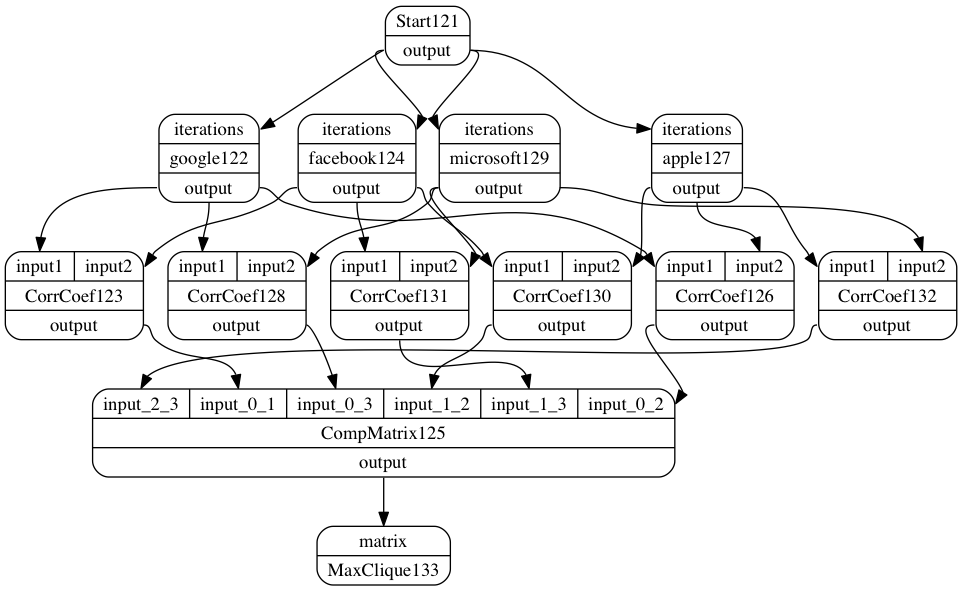

Preparing for: 4 projections


In [28]:
#####################################################################################################

#Declare workflow inputs: (each iteration prduces a batch_size of samples at the specified sampling_rate)
# number of projections = iterations/batch_size at speed defined by sampling rate
variables_number=4
sampling_rate=100
batch_size=4
iterations=16

inputs_stock = {
    0: { 
        'name': 'google'
    },
    1:{ 
        'name': 'facebook'
    },
    2:{ 
        'name': 'apple'
    },
    3:{ 
        'name': 'microsoft'
    },
} 


input_data = {"Start": [{"iterations": [iterations]}]}
      
# Instantiates the Workflow Components  
# and generates the graph based on parameters

def createWf():
    graph = WorkflowGraph()
    plot=CompMatrix(variables_number)
    mc = MaxClique(-0.01)
    start=Start() 
    sources={}

    for i in range(0,variables_number):
        sources[i] = Source(sampling_rate,i, inputs_stock[i]['name'])

    for h in range(0,variables_number):
        graph.connect(start,'output',sources[h],'iterations')
        for j in range(h+1,variables_number):
            cc=CorrCoef(batch_size,(h,j))
            plot._add_input('input'+'_'+str(h)+'_'+str(j),grouping=[1])
            graph.connect(sources[h],'output',cc,'input1')
            graph.connect(sources[j],'output',cc,'input2')
            graph.connect(cc,'output',plot,'input'+'_'+str(h)+'_'+str(j))
            cc.numprocesses=1
    
    graph.connect(plot,'output',mc,'matrix')
   
    return graph
        

graph=createWf()
#Visualise the graph
from dispel4py.visualisation import display
display(graph)

print ("Preparing for: "+str(iterations/batch_size)+" projections" )

### Execution without provenance
The followin instruction executes the workflow in single-process mode with no provenance
<br/>

SETTING NAME: SimpleProcessingPE


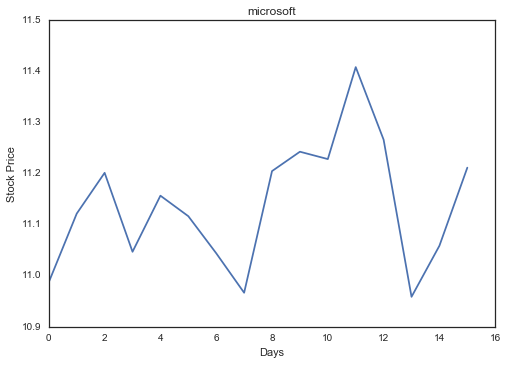

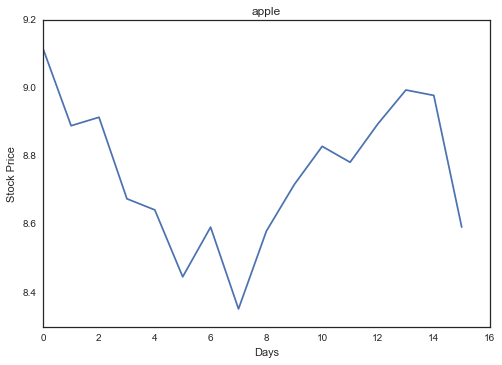

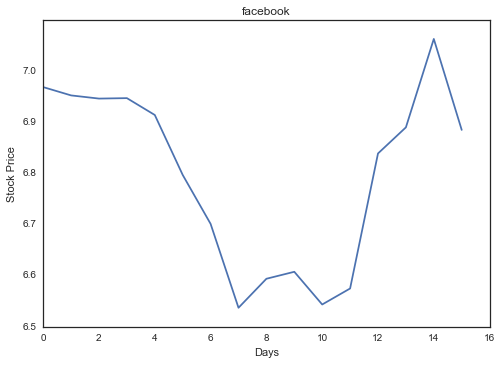

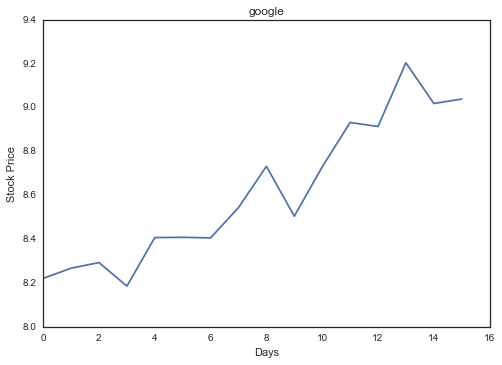

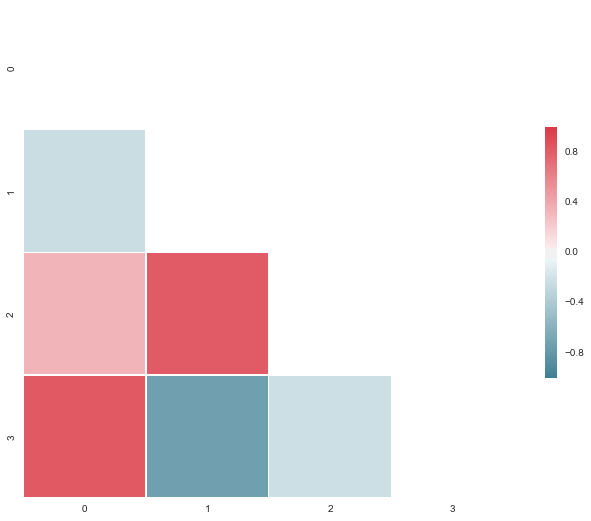

CompMatrix125: [[ 1.          0.          0.          0.        ]
 [-0.23822987  1.          0.          0.        ]
 [ 0.33497453  0.81961234  1.          0.        ]
 [ 0.83181997 -0.73359995 -0.22074543  1.        ]]


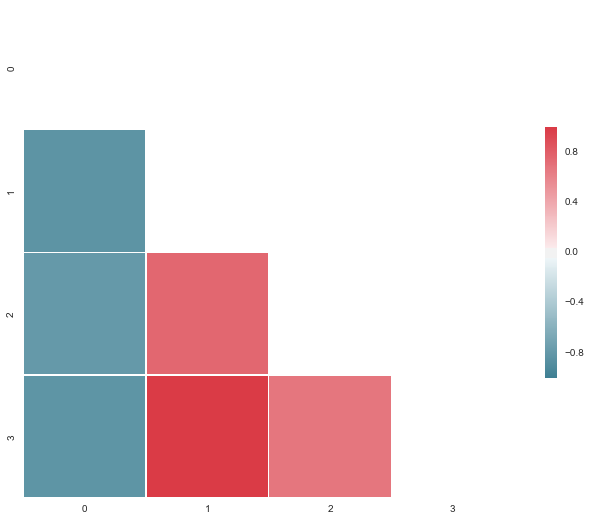

CompMatrix125: [[ 1.          0.          0.          0.        ]
 [-0.83280765  1.          0.          0.        ]
 [-0.78722462  0.75780107  1.          0.        ]
 [-0.8241239   0.99242033  0.67858662  1.        ]]


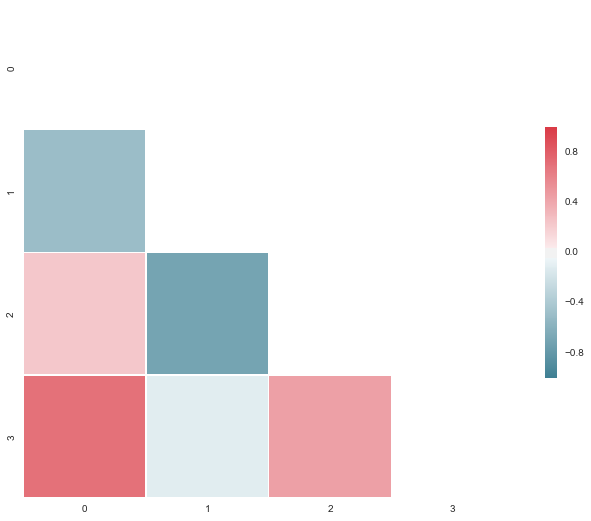

CompMatrix125: [[ 1.          0.          0.          0.        ]
 [-0.49526301  1.          0.          0.        ]
 [ 0.23051037 -0.70214979  1.          0.        ]
 [ 0.69915156 -0.109785    0.43913453  1.        ]]


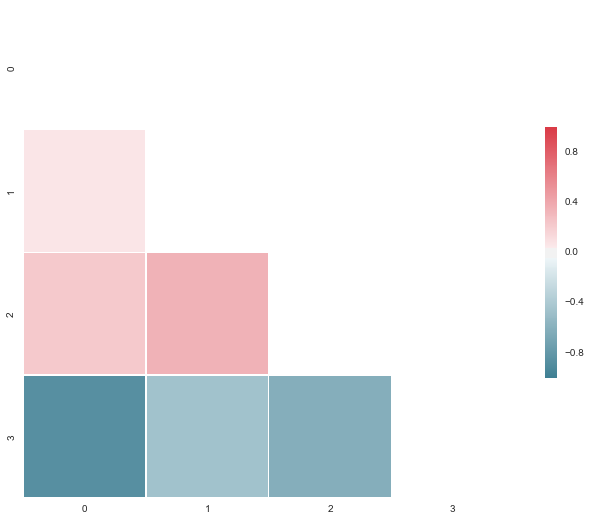

CompMatrix125: [[ 1.          0.          0.          0.        ]
 [ 0.06494421  1.          0.          0.        ]
 [ 0.22643678  0.35114542  1.          0.        ]
 [-0.86301147 -0.45570707 -0.61181834  1.        ]]
MaxClique133: [[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.33497453  0.81961234  1.          0.        ]
 [ 0.83181997  0.          0.          1.        ]]
MaxClique133: [[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.75780107  1.          0.        ]
 [ 0.          0.99242033  0.67858662  1.        ]]
MaxClique133: [[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.23051037  0.          1.          0.        ]
 [ 0.69915156  0.          0.43913453  1.        ]]
MaxClique133: [[ 1.          0.          0.          0.        ]
 [ 0.06494421  1.          0.          0.        ]
 [ 0.22

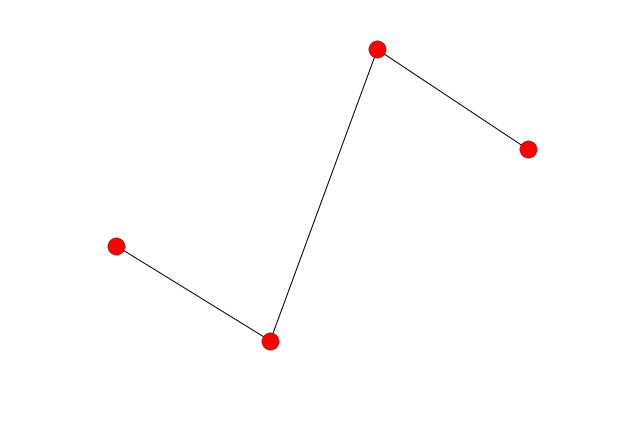

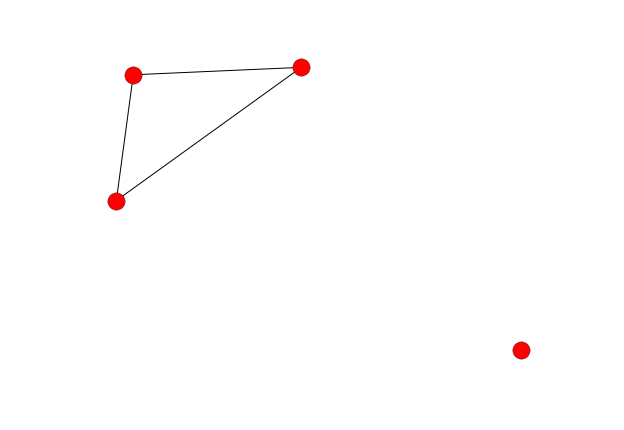

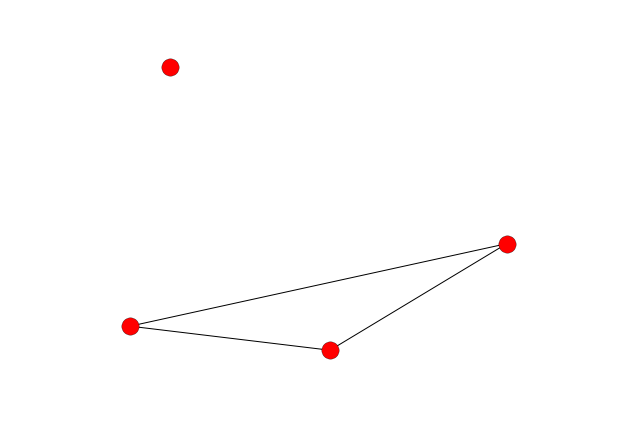

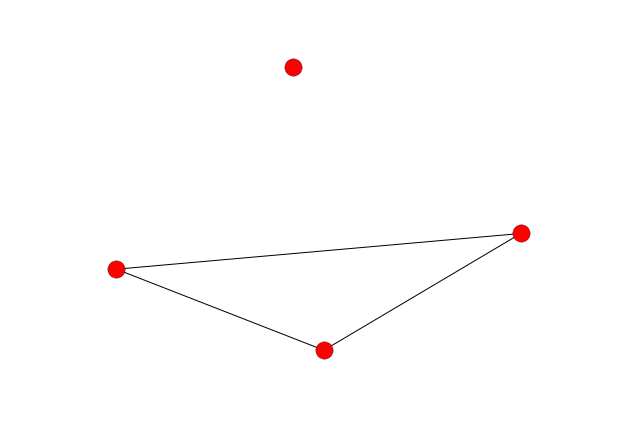

In [29]:
#Launch in simple process
start_time = time.time()
process_and_return(graph, input_data)
elapsed_time = time.time() - start_time
print ("ELAPSED TIME: "+str(elapsed_time))

## Preparing the workflow graph for provenance production, pre-analysis and storage

This snippet will make sure that the workflow compoentns will be provenance-aware and the lineage information sent to the designated ProvenanceRecorders for in-workflow pre-analysis.

The execution will show a new graph where it will be possible to validate the provenance-cluster, if any, and the correct association of ProvenanceRecorders and feedback connections.

The graph will change according to the declaration of self.prov_cluster property of the processing elements and to the specification of different ProvenanceRecorders and feedback loops, as described below:

### Function InitiateNewRun 
Prepares the workflow with the required provenance mechanisms
The accepted parameters are the following:

#### Unnamed parameters:
<li> 1 - <i>worfklow graph</i></li>
<li> 2 - Class name implementing the default <i>ProvenanceRecorder</i></li>

#### Named Parameters
<li> 3 - <i>provImpClass</i>: Class name extending the default <i>ProvenancePE</i>. The current type of the workflow components (GenericPE) will be extended with the one indicated by the <i>provImpClass</i> type</li>
<li> 4 - <i>username</i></li>
<li> 5 - <i>runId</i></li>
<li> 6 - <i>w3c_prov</i>: specifies if the PE will outupt lineage in PROV format (default=False)</li>
<li> 7 - <i>workflowName</i></li>
<li> 8 - <i>workflowId</i></li>
<li> 9 - <i>clustersRecorders</i>: dictionary associating <i>provenance-clusters</i> with a specific <i>ProvenanceRecorder</i> (overrides the default <i>ProvenanceRecorder</i>) </li>
<li> 10 - <i>feedbackPEs</i>: list of PE names receiving and processing feedbacks from the <i>ProvenanceRecorder</i>. </li>

<br/>




SETTING NAME: CompMatrix
SETTING NAME: MaxClique
SETTING NAME: Start
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: NewWorkflowRun
SETTING NAME: ProvenanceRecorderToServiceBulk
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
SETTING NAME: SimpleProcessingPE
RUN Metadata: {'username': 'rayson', 'workflowId': 'xx', 'description': 'provState', 'mapping': '-f', 'system_id': None, 'runId': 'RDWD_Rayson-MacBook-Pro.local-1947-fd5fa905-9c20-11e6-a45d-a45e60b75575', 'startTime': '2016-10-27 08:40:18.517601', 'input': [], '_id': 'RDWD_Rayson-MacBook-Pro.local-1947-fd5fa905-9c20-11e6-a45d-a45e60b75575', 'type': 'workflow_run', 'workflowName': 'test_rdwd'}
SimplePE: Processed 1 iteration.
Outputs: {}
Change grouping implementation 
Change grouping implementation 
Injecting provenance to: CompMatrix Original typ

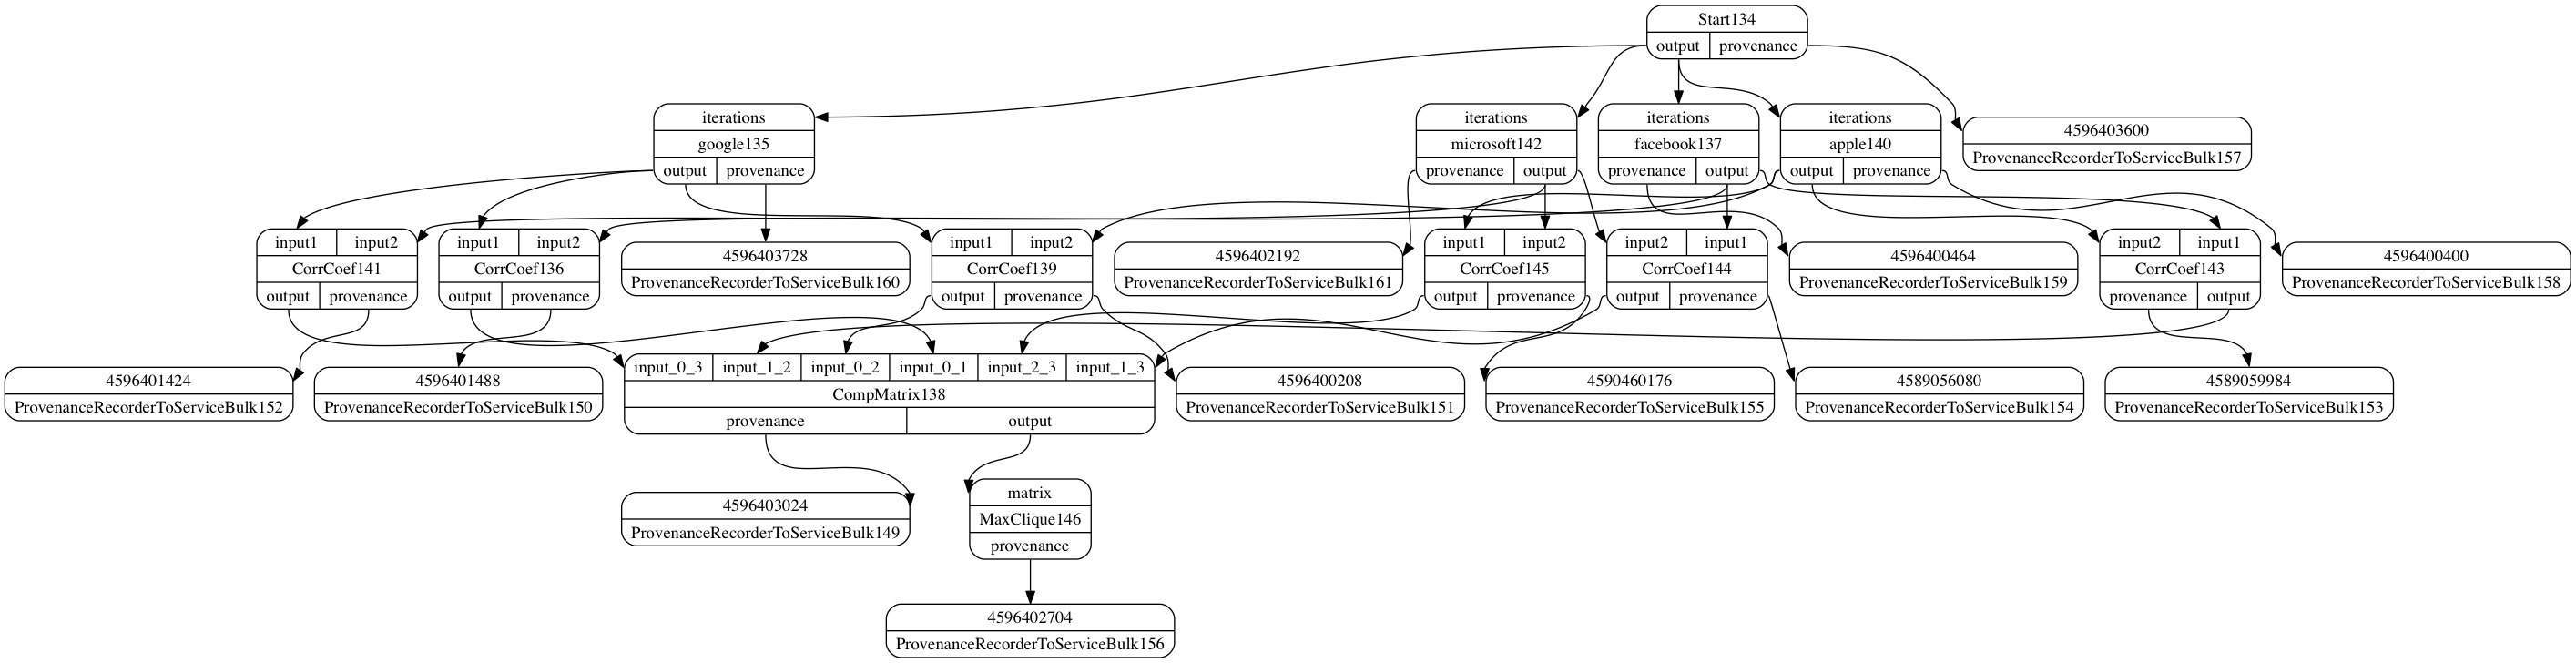

In [30]:
ProvenanceRecorder.REPOS_URL='http://verce-portal-dev.scai.fraunhofer.de/j2ep-1.0/prov/workflow/insert'

def createGraphWithProv():
    
    graph=createWf()
    #Location of the remote repository for runtime updates of the lineage traces. Shared among ProvenanceRecorder subtypes

    # Ranomdly generated unique identifier for the current run
    rid='RDWD_'+getUniqueId()

    # if ProvenanceRecorderToFile is used, this path will contains all the resulting JSON documents
    os.environ['PROV_PATH']="./prov-files/"

    # Finally, provenance enhanced graph is prepared:
    InitiateNewRun(graph,ProvenanceRecorderToServiceBulk,provImpClass=ProvenancePE,username='rayson',runId=rid,w3c_prov=False,description="provState",workflowName="test_rdwd",workflowId="xx")
    
    return graph
#.. and visualised..
graph=createGraphWithProv()

display(graph)

### Execution with provenance
The followin instruction executes the workflow in single-process mode
<br/>

SETTING NAME: SimpleProcessingPE


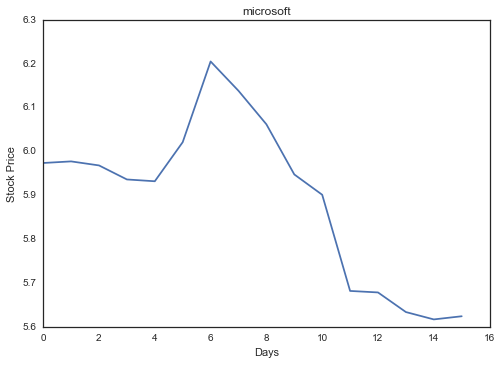

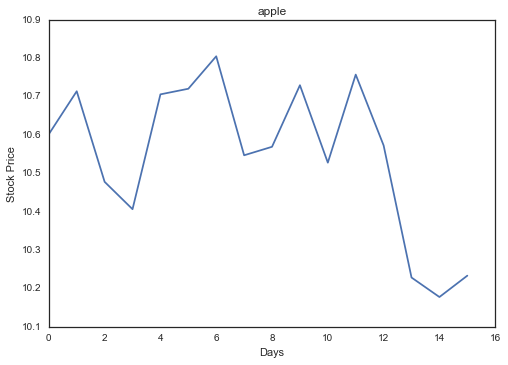

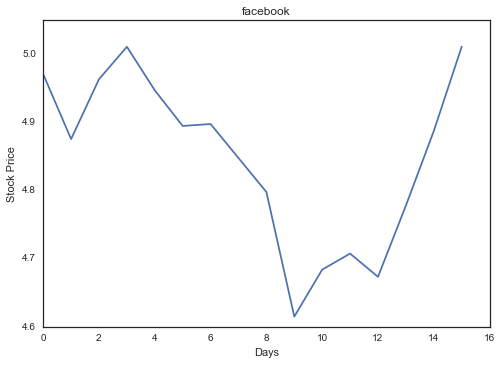

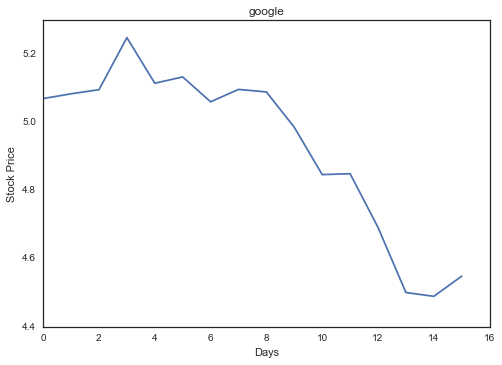

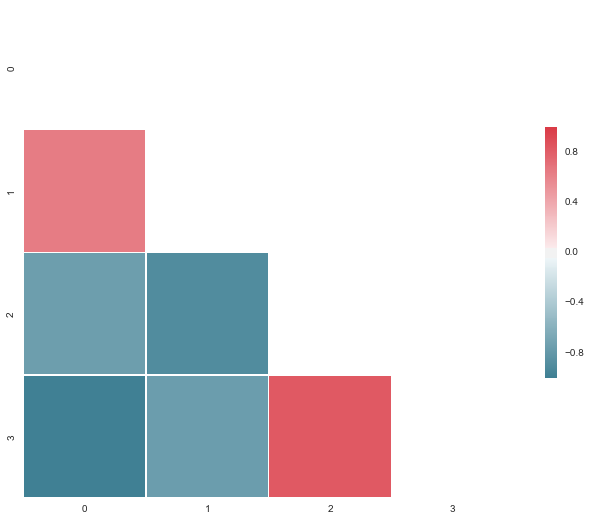

CompMatrix138: [[ 1.          0.          0.          0.        ]
 [ 0.63511284  1.          0.          0.        ]
 [-0.74294929 -0.89595953  1.          0.        ]
 [-0.98612953 -0.7532234   0.83183435  1.        ]]


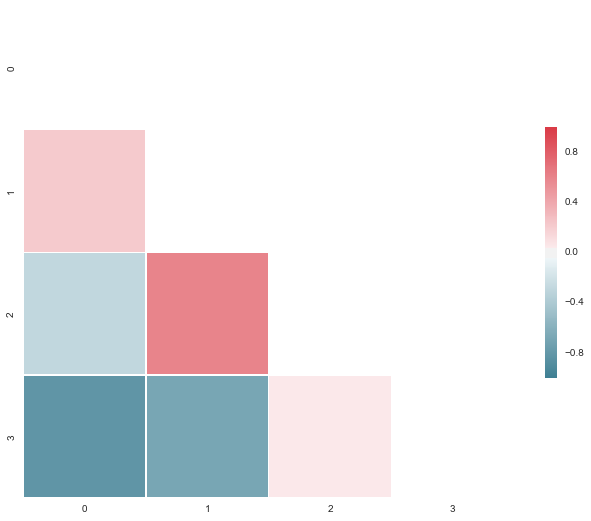

CompMatrix138: [[ 1.          0.          0.          0.        ]
 [ 0.21291862  1.          0.          0.        ]
 [-0.28520682  0.59860493  1.          0.        ]
 [-0.81801667 -0.6811735   0.05206956  1.        ]]


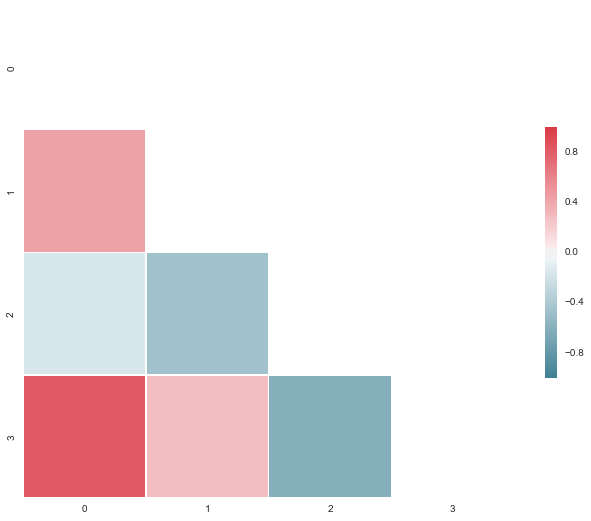

CompMatrix138: [[ 1.          0.          0.          0.        ]
 [ 0.4343664   1.          0.          0.        ]
 [-0.16742243 -0.45889366  1.          0.        ]
 [ 0.82182953  0.28127617 -0.60182945  1.        ]]


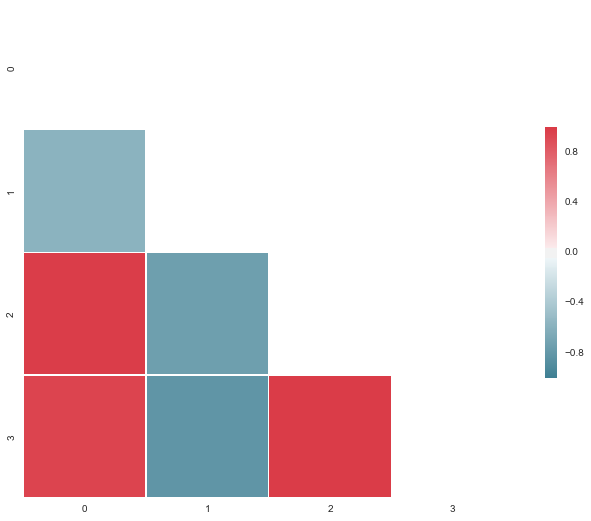

CompMatrix138: [[ 1.          0.          0.          0.        ]
 [-0.58274503  1.          0.          0.        ]
 [ 0.97892586 -0.73638633  1.          0.        ]
 [ 0.93773541 -0.81851959  0.98593782  1.        ]]
MaxClique146: [[ 1.          0.          0.          0.        ]
 [ 0.63511284  1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.83183435  1.        ]]
MaxClique146: [[ 1.          0.          0.          0.        ]
 [ 0.21291862  1.          0.          0.        ]
 [ 0.          0.59860493  1.          0.        ]
 [ 0.          0.          0.05206956  1.        ]]
MaxClique146: [[ 1.          0.          0.          0.        ]
 [ 0.4343664   1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.82182953  0.28127617  0.          1.        ]]
MaxClique146: [[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.97

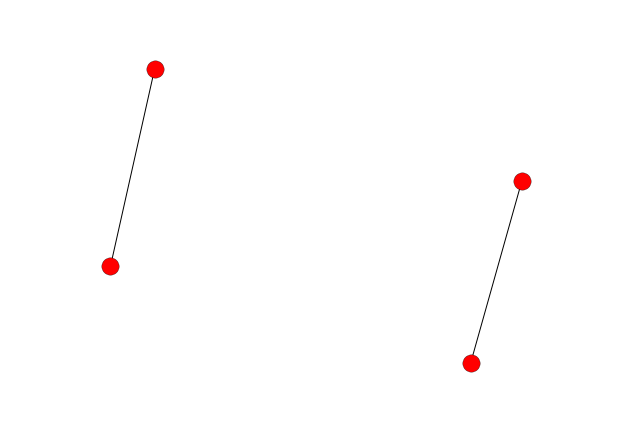

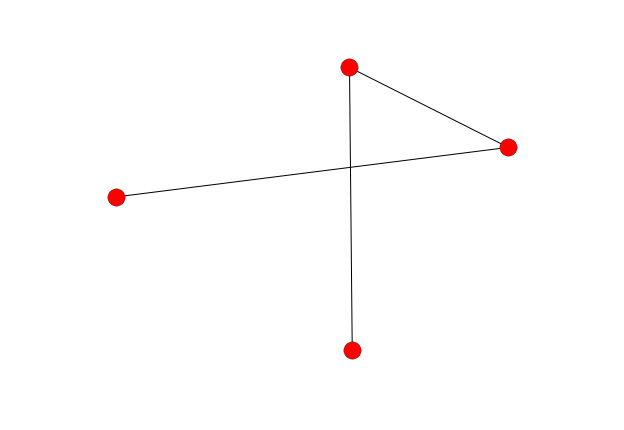

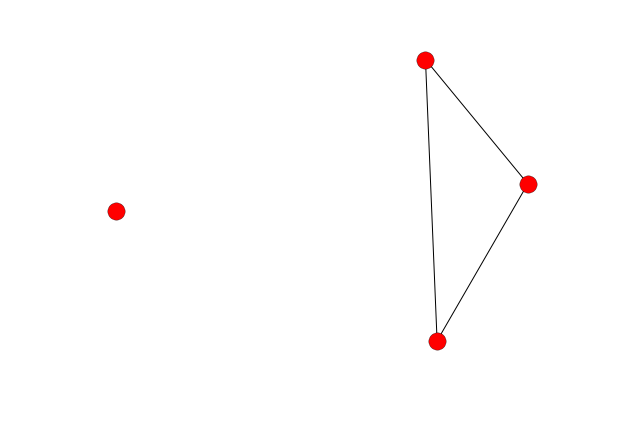

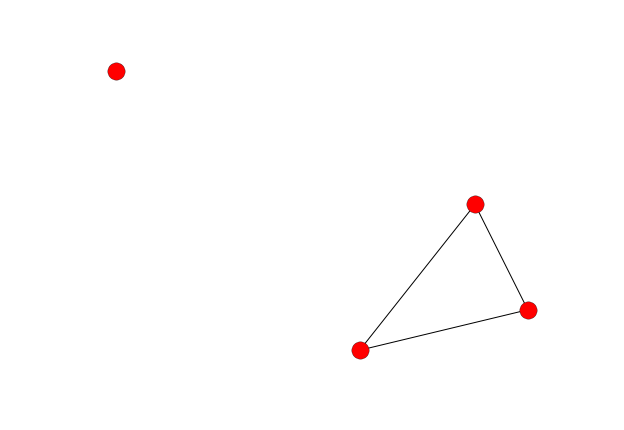

In [31]:
#graph = createGraphWithProv()
#Launch in simple process
start_time = time.time()
process_and_return(graph, input_data)
elapsed_time = time.time() - start_time
print ("ELAPSED TIME: "+str(elapsed_time))

SETTING NAME: CompMatrix
SETTING NAME: MaxClique
SETTING NAME: Start
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
Processes: {'MaxClique174': [7], 'Start162': [0], 'microsoft170': [2], 'CompMatrix166': [5], 'CorrCoef171': [6], 'CorrCoef172': [3], 'CorrCoef173': [9], 'CorrCoef167': [1], 'facebook165': [4], 'CorrCoef164': [8], 'CorrCoef169': [12], 'google163': [10], 'apple168': [11]}
Start162 (rank 0): Processed 1 iteration.
microsoft170 (rank 2): Processed 1 iteration.
CorrCoef172 (rank 3): Processed 32 iterations.
facebook165 (rank 4): Processed 1 iteration.
google163 (rank 10): Processed 1 iteration.
CorrCoef169 (rank 12): Processed 32 iterations.
CorrCoef164 (rank 8): Processed 32 iterations.
CorrCoef167 (rank 1): Processed 32 iterations.
CorrCoef171 (rank 6): Processed 32 iterations.
CorrCoef173 (rank 9): Pro

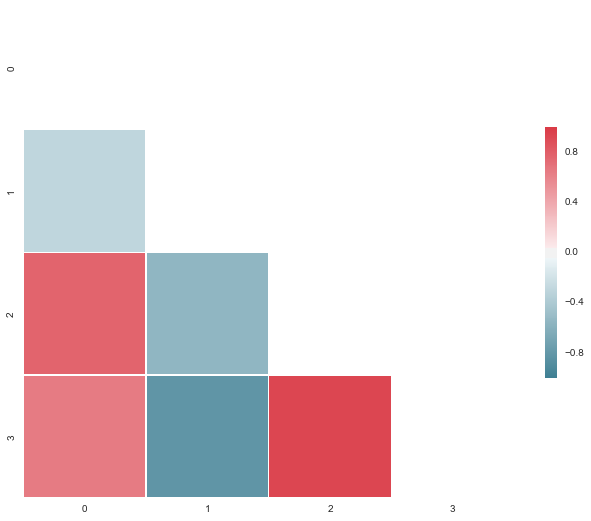

CompMatrix166 (rank 5): [[ 1.          0.          0.          0.        ]
 [-0.28960156  1.          0.          0.        ]
 [ 0.77241992 -0.55094905  1.          0.        ]
 [ 0.64466594 -0.81862466  0.92994997  1.        ]]
MaxClique174 (rank 7): [[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.77241992  0.          1.          0.        ]
 [ 0.64466594  0.          0.92994997  1.        ]]


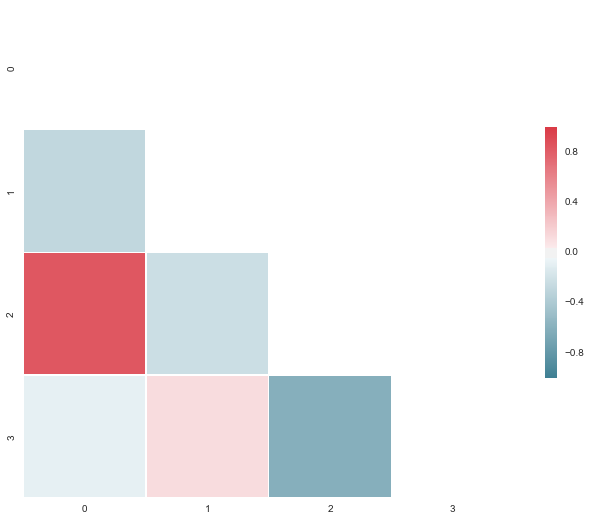

CompMatrix166 (rank 5): [[ 1.          0.          0.          0.        ]
 [-0.28643658  1.          0.          0.        ]
 [ 0.83840138 -0.23228022  1.          0.        ]
 [-0.07985289  0.11892167 -0.60662223  1.        ]]
MaxClique174 (rank 7): [[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.83840138  0.          1.          0.        ]
 [ 0.          0.11892167  0.          1.        ]]


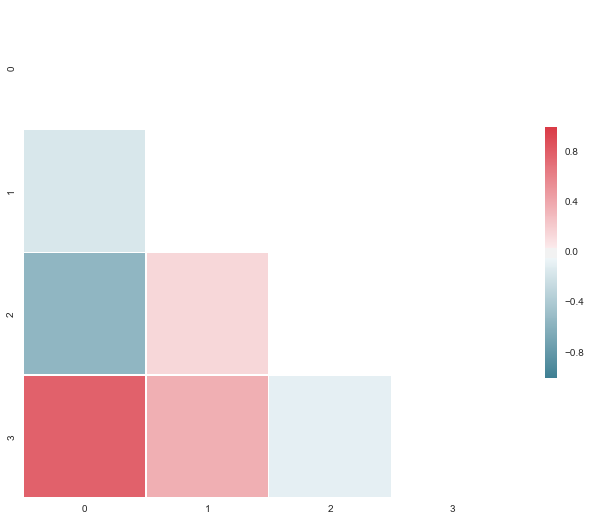

CompMatrix166 (rank 5): [[ 1.          0.          0.          0.        ]
 [-0.1600182   1.          0.          0.        ]
 [-0.55105674  0.1467178   1.          0.        ]
 [ 0.78185908  0.36679975 -0.08945542  1.        ]]
CompMatrix166 (rank 5): Processed 24 iterations.
MaxClique174 (rank 7): [[ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.1467178   1.          0.        ]
 [ 0.78185908  0.36679975  0.          1.        ]]
MaxClique174 (rank 7): Processed 4 iterations.
ELAPSED TIME: 2.51268100739


In [32]:
#Launch in multi process

import argparse
from dispel4py.new.multi_process import process

args = argparse.Namespace
args.num = 24
args.simple = False
graph = createWf()
#createGraphWithProv()
start_time = time.time()
process(graph, inputs=input_data, args=args)
elapsed_time = time.time() - start_time
print ("ELAPSED TIME: "+str(elapsed_time))


#process_and_return(graph, input_data)

In [33]:
class ProvenanceRecorderToService(ProvenanceRecorder):

    def __init__(self, name='ProvenanceRecorderToService', toW3C=False):
        ProvenanceRecorder.__init__(self)
        self.name = name
        self.convertToW3C = toW3C
        # self.inputconnections[ProvenanceRecorder.INPUT_NAME] = {
        # "name": ProvenanceRecorder.INPUT_NAME}

    def _preprocess(self):
        self.provurl = urlparse(ProvenanceRecorder.REPOS_URL)
        self.connection = httplib.HTTPConnection(
            self.provurl.netloc)

    def _process(self, inputs):
        
        #ports are assigned automatically as numbers, we just need to read from any of these
        for x in inputs:
            prov = inputs[x]
            
        out = None
        if isinstance(prov, list) and "data" in prov[0]:
            prov = prov[0]["data"]

        if self.convertToW3C:
            out = toW3Cprov(prov)
        else:
            out = prov

        params = urllib.urlencode({'prov': json.dumps(out)})
        headers = {
            "Content-type": "application/x-www-form-urlencoded",
            "Accept": "application/json"}
        self.connection.request(
            "POST",
            self.provurl.path,
            params,
            headers)

        response = self.connection.getresponse()
        print("Response From Provenance Serivce: ", response.status,
              response.reason, response, response.read())
        self.connection.close()
        return None

    def postprocess(self):
        self.connection.close()

### MyProvenanceRecorderWithFeedback

Recieves traces from the PEs and reads its content. Depending from the 'name' of the PE sending the lineage, feedbacks are prepared and sent back.

## Developing ProvenanceRecorders

The Class below show a sample <i>ProvenanceRecorderToService</i> and a slightlty more advanced one that allows for feedback.

### ProvenanceRecorderToService

Recieves traces from the PEs and sends them out to an exteranal provenance store.



In [34]:
class MyProvenanceRecorderWithFeedback(ProvenanceRecorder):

    def __init__(self, toW3C=False):
        ProvenanceRecorder.__init__(self)
        self.convertToW3C = toW3C
        self.bulk = []
        self.timestamp = datetime.datetime.utcnow()

    def _preprocess(self):
        self.provurl = urlparse(ProvenanceRecorder.REPOS_URL)

        self.connection = httplib.HTTPConnection(
            self.provurl.netloc)

    def postprocess(self):
        self.connection.close()
        
    def _process(self, inputs):
        prov = None
        for x in inputs:
            prov = inputs[x]
        out = None
        if isinstance(prov, list) and "data" in prov[0]:
            prov = prov[0]["data"]

        if self.convertToW3C:
            out = toW3Cprov(prov)
        else:
            out = prov

            
            
        self.write(self.porttopemap[prov['name']], "FEEDBACK MESSAGGE FROM RECORDER")

        self.bulk.append(out)
        params = urllib.urlencode({'prov': json.dumps(self.bulk)})
        headers = {
            "Content-type": "application/x-www-form-urlencoded",
            "Accept": "application/json"}
        self.connection.request(
            "POST", self.provurl.path, params, headers)
        response = self.connection.getresponse()
        self.log("progress: " + str((response.status, response.reason,
                                         response, response.read())))
        

        return None

## Active provenance with feedback
Here we show how to implement a PE that can handle feedback from a <i>ProvenanceRecoder</i>. We redefine the worklow graph with the same structure as the provious one but with the new PE

### Class DivFeedback
It requires the implementation of the <i>_process_feedbak</i> function. The function will be invoked automatically by the framework when a feedback is sent.
<br/>

In [38]:
class DivFeedback(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input')
        self._add_output('output')
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'self.prov_cluster='mycluster'
         
         
        
    def _process_feedback(data):
        print "FEEEEDBACK: "+str(data)
    
    def _process(self,data):
        self.log("DIIIIV: "+str(data)) 
        val = data['input'][0]/data['input'][1]
        self.write('output',val,metadata={'val':val})

        
# Relevant example, Similar with the Start Class above, it just added with prov
class StartFB(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        #self.prov_cluster="myne"
    
    def _process(self,inputs):
        
        if 'iterations' in inputs:
            inp=inputs['iterations']
             
            self.write('output',inp,metadata={'val':inp})
            
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        self.prov_cluster ='stocks'
        
    def _process_feedback(data):
        print "FINAL FEEDBACK FROM PREVIOUS EXECUTION: " + str(data)
     

SETTING NAME: CompMatrix
SETTING NAME: MaxClique
SETTING NAME: StartFB
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: CorrCoef
SETTING NAME: NewWorkflowRun
SETTING NAME: ProvenanceRecorderToServiceBulk
Inputs: {'NewWorkflowRun': [{'input': 'None'}]}
SETTING NAME: SimpleProcessingPE
RUN Metadata: {'username': 'rayson', 'workflowId': 'stockStimulation', 'description': 'provState', 'mapping': '-f', 'system_id': None, 'runId': 'RDWD_Rayson-MacBook-Pro.local-1947-5668cc57-9c38-11e6-888c-a45e60b75575', 'startTime': '2016-10-27 11:27:26.356190', 'input': [], '_id': 'RDWD_Rayson-MacBook-Pro.local-1947-5668cc57-9c38-11e6-888c-a45e60b75575', 'type': 'workflow_run', 'workflowName': 'test_stockFB'}
SimplePE: Processed 1 iteration.
Outputs: {}
Change grouping implementation 
Change grouping implementation 
Injecting provenance to: Comp

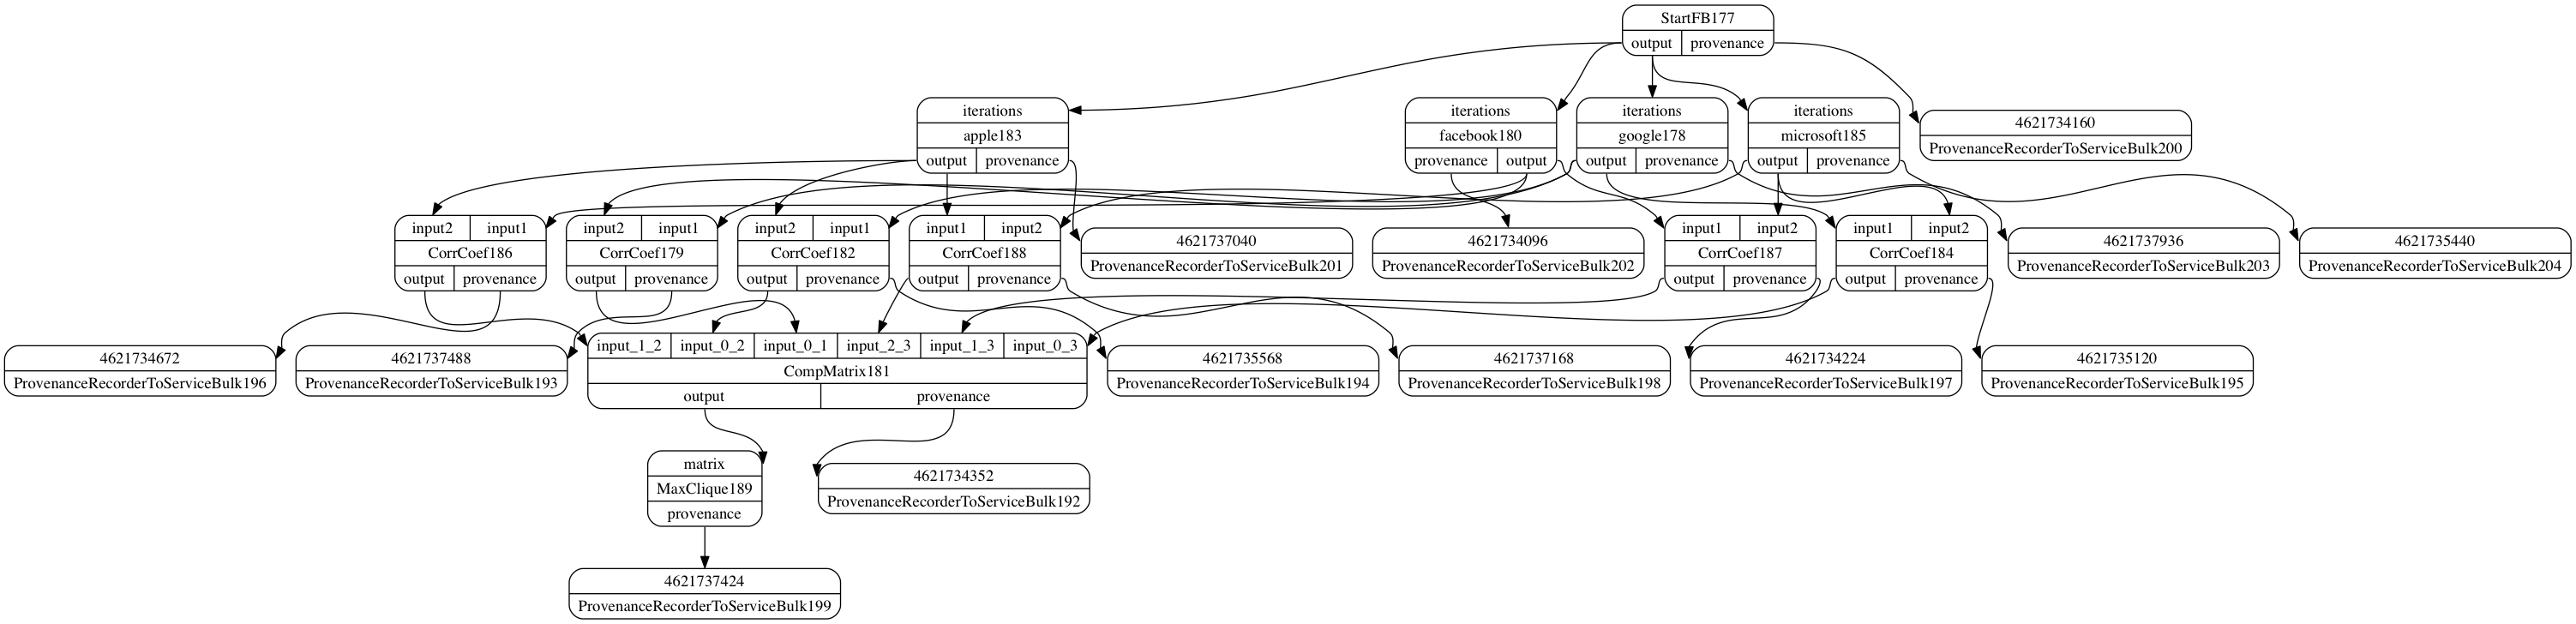

In [39]:
#Recoreders' dictionary
clustersRecorders={}

def createGraphWithProvFB():
    
    graph = WorkflowGraph()
    plot=CompMatrix(variables_number)
    mc = MaxClique(-0.01)
    start=StartFB() 
    clustersRecorders['stocks']=MyProvenanceRecorderWithFeedback
    sources={}

    for i in range(0,variables_number):
        sources[i] = Source(sampling_rate,i, inputs_stock[i]['name'])

    for h in range(0,variables_number):
        graph.connect(start,'output',sources[h],'iterations')
        for j in range(h+1,variables_number):
            cc=CorrCoef(batch_size,(h,j))
            plot._add_input('input'+'_'+str(h)+'_'+str(j),grouping=[1])
            graph.connect(sources[h],'output',cc,'input1')
            graph.connect(sources[j],'output',cc,'input2')
            graph.connect(cc,'output',plot,'input'+'_'+str(h)+'_'+str(j))
            cc.numprocesses=1
    
    graph.connect(plot,'output',mc,'matrix')
   
    # Ranomdly generated unique identifier for the current run
    rid='RDWD_'+getUniqueId()

    # if ProvenanceRecorderToFile is used, this path will contains all the resulting JSON documents
    os.environ['PROV_PATH']="./prov-files/"

    # Finally, provenance enhanced graph is prepared:
    InitiateNewRun(graph,ProvenanceRecorderToServiceBulk,provImpClass=ProvenancePE,username='rayson',runId=rid,w3c_prov=False,description="provState",workflowName="test_stockFB",workflowId="stockStimulation", clustersRecorders=clustersRecorders, feedbackPEs=['SourceFB'])
    
    return graph
#.. and visualised..
graph=createGraphWithProvFB()

display(graph)

In [40]:
start_time = time.time()
process_and_return(graph, input_data)
elapsed_time = time.time() - start_time
print ("ELAPSED TIME: "+str(elapsed_time))

SETTING NAME: SimpleProcessingPE
SimplePE: Processed 1 iteration.
ELAPSED TIME: 7.02752590179


### Preparing the Workflow with the requires clusters, recorders and feedback 

In [36]:
# Instantiates the Workflow Components        


# Instantiates the Workflow Components  
# and generates the graph based on parameters

sources={}
graph = WorkflowGraph()
plot=PlotData(variables_number)    
start=aw()   

#Recoreders' dictionary
clustersRecorders={}

for i in range(0,variables_number):
    sources[i] = Source(sampling_rate,i,inputs_stock[i]['name'])
    #sources[i].prov_cluster='mycluster_src'
    clustersRecorders['mycluster_src']=MyProvenanceRecorderWithFeedback
        
    

for h in range(0,variables_number):
    graph.connect(start,'output',sources[h],'iterations')
    for j in range(h+1,variables_number):
        cc=CorrCoef(batch_size,(h,j))
        plot._add_input('input'+'_'+str(h)+'_'+str(j),grouping=[1])
        graph.connect(sources[h],'output',cc,'input1')
        graph.connect(sources[j],'output',cc,'input2')
        #sources[h].prov_cluster='mycluster_'+str(h)
        #sources[j].prov_cluster='mycluster_'+str(j)
        #cc.prov_cluster='mycluster_xcorr'
        
        #Associates recorders to clusters
        graph.connect(cc,'output',plot,'input'+'_'+str(h)+'_'+str(j))
        clustersRecorders['mycluster_xcorr']=MyProvenanceRecorderWithFeedback
        

#Visualise the graph
from dispel4py.visualisation import display

print ("Preparing for: "+str(iterations/batch_size)+" projections" )


from IPython.display import HTML
HTML('Simple Graph <br/>')
display(graph)

# Preparing the workflow graph for provenance production, pre-analysis and storage
# Ranomdly generated unique identifier for the current run
rid='RDWD_'+getUniqueId()

# if ProvenanceRecorderToFile is used, this path will contains all the resulting JSON documents
os.environ['PROV_PATH']="./prov-files/"

# Finally, provenance enhanced graph is prepared:
InitiateNewRun(graph,ProvenanceRecorderToServiceBulk,provImpClass=ProvenancePE,username='rayson',runId=rid,w3c_prov=False,workflowName="test_rdwd",workflowId="xx",clustersRecorders=clustersRecorders)
#feedbackPEs=['Source','CorrCoef'])

#.. and visualised..

display(graph)

SETTING NAME: Start
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: Source
SETTING NAME: CorrCoef


NameError: name 'plot' is not defined

### Execution with Feedback
As a temporary requirement, feedback workflows have to bee executed in multiprocessing mode
<br/>


In [ ]:
#Launch in multi process

import argparse
from dispel4py.new.multi_process import process

args = argparse.Namespace
args.num = 24
args.simple = False
graph = createGraphWithProv()
process(graph, inputs=input_data, args=args)


#process_and_return(graph, input_data)